In [2]:
# # Check if there are compatible versions
# !pip install tensorflow-decision-forests==1.8.0  # Replace with the correct version if needed
# !pip install tensorflow-serving-api==2.15.1
# !pip install tensorflow-text==2.12.1
# !pip install tf-keras==2.15.1
# !pip install ml-dtypes==0.4.0  # Assuming this is okay


In [3]:
# !pip install gdown
# !pip install py7zr
# !pip install tensorflow==2.15.1

# Download Dataset

In [4]:
import gdown
import os
import py7zr

# Link from GitHub
google_drive_link = 'https://drive.google.com/file/d/1pEnxoKSt1rNeODmdsMMTTspKLL8vNqEM/view?usp=drive_link'

# Extract the file ID from the link
file_id = google_drive_link.split('/')[-2]

# Create the direct download URL
download_url = f'https://drive.google.com/uc?id={file_id}'

# Define the output file path for the downloaded file
output_path = '/kaggle/working/downloaded_file.7z'  # Change the extension to .7z

# Download the file
gdown.download(download_url, output_path, quiet=False)

# Verify the download
if os.path.exists(output_path):
    print("File downloaded successfully.")

    # Un7z the file
    with py7zr.SevenZipFile(output_path, mode='r') as archive:
        archive.extractall('/content/dataset_fix')  # Extract to the specified directory
    print("File extracted successfully.")
else:
    print("Failed to download the file.")


Downloading...
From (original): https://drive.google.com/uc?id=1pEnxoKSt1rNeODmdsMMTTspKLL8vNqEM
From (redirected): https://drive.google.com/uc?id=1pEnxoKSt1rNeODmdsMMTTspKLL8vNqEM&confirm=t&uuid=04e542ae-bfb3-4085-a23d-40e352d39a3c
To: /kaggle/working/downloaded_file.7z
100%|██████████| 1.02G/1.02G [00:11<00:00, 86.8MB/s]


File downloaded successfully.
File extracted successfully.


In [5]:
import os

def print_image_counts(data_dir):
    # Directories for Train, Val, and Test
    datasets = ['Train', 'Val', 'Test']

    for dataset in datasets:
        dataset_path = os.path.join(data_dir, dataset)

        print(f"Image counts for {dataset} dataset:")

        # Iterate through each class folder
        for class_name in os.listdir(dataset_path):
            class_path = os.path.join(dataset_path, class_name)
            if os.path.isdir(class_path):  # Check if it's a directory
                image_count = len(os.listdir(class_path))
                print(f"  {class_name}: {image_count} images")

        print()  # Print a newline for better readability

# Usage
print_image_counts('/content/dataset_fix/plant-village-fix-updated')


Image counts for Train dataset:
  potato_healthy: 1824 images
  apple_healthy: 2008 images
  tomato_yellow-leaf-curl-virus: 1961 images
  potato_early-blight: 1939 images
  grape_black-rot: 1888 images
  tomato_late-blight: 1851 images
  corn_northern-leaf-blight: 1908 images
  pepper_bacterial-spot: 1913 images
  tomato_early-blight: 1920 images
  apple_cedar-apple-rust: 1760 images
  pepper_healthy: 1988 images
  tomato_bacterial-spot: 1702 images
  potato_late-blight: 1939 images
  tomato_septoria-leaf-spot: 1746 images
  cherry_powdery-mildew: 1683 images
  apple_black-rot: 1987 images
  corn_cercospora-leaf-spot: 1642 images
  tomato_healthy: 1926 images
  grape_healthy: 1692 images
  peach_healthy: 1728 images
  strawberry_leaf-scorch: 1774 images
  corn_healthy: 1859 images
  strawberry_healthy: 1824 images
  grape_esca: 1920 images
  corn_common-rust: 1907 images
  cherry_healthy: 1826 images
  grape_leaf-blight: 1722 images
  apple_scab: 2016 images
  peach_bacterial-spot: 183

## Delete some ipynb checkpoint

In [6]:
import os
import shutil

# Define the root directory path
root_directory = '/content/dataset_fix'

# Walk through the directory
for root, dirs, files in os.walk(root_directory):
    for dir_name in dirs:
        if dir_name == '.ipynb_checkpoints':
            # Construct the full path to the .ipynb_checkpoints directory
            dir_path = os.path.join(root, dir_name)
            # Delete the directory
            shutil.rmtree(dir_path)
            print(f'Deleted: {dir_path}')


Deleted: /content/dataset_fix/plant-village-fix-updated/Train/tomato_septoria-leaf-spot/.ipynb_checkpoints
Deleted: /content/dataset_fix/plant-village-fix-updated/Test/corn_cercospora-leaf-spot/.ipynb_checkpoints


# Import Library

In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
import tensorflow_hub as hub
import time

2024-10-05 00:33:21.998747: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-05 00:33:21.998806: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-05 00:33:22.000177: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Preproccesing data

## Create the label list and train dataset

In [8]:
import os

class Dataset:
    # Class variable to store folder names
    class_names = []

    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.load_class_names()

    def load_class_names(self):
        # Path to the Train directory
        train_dir = os.path.join(self.data_dir, 'Train')

        # List folder names inside the Train directory
        if os.path.exists(train_dir):
            self.class_names = [folder for folder in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, folder))]
        else:
            print(f"The directory {train_dir} does not exist.")

# Usage
data_directory = '/content/dataset_fix/plant-village-fix-updated'  # Change this to your actual path
dataset = Dataset(data_directory)
disease_types = dataset.class_names
print("Class names:", disease_types)


Class names: ['potato_healthy', 'apple_healthy', 'tomato_yellow-leaf-curl-virus', 'potato_early-blight', 'grape_black-rot', 'tomato_late-blight', 'corn_northern-leaf-blight', 'pepper_bacterial-spot', 'tomato_early-blight', 'apple_cedar-apple-rust', 'pepper_healthy', 'tomato_bacterial-spot', 'potato_late-blight', 'tomato_septoria-leaf-spot', 'cherry_powdery-mildew', 'apple_black-rot', 'corn_cercospora-leaf-spot', 'tomato_healthy', 'grape_healthy', 'peach_healthy', 'strawberry_leaf-scorch', 'corn_healthy', 'strawberry_healthy', 'grape_esca', 'corn_common-rust', 'cherry_healthy', 'grape_leaf-blight', 'apple_scab', 'peach_bacterial-spot']


In [9]:
data_dir = '/content/dataset_fix/plant-village-fix-updated'
train_dir = os.path.join(data_dir + "/Train")
val_dir = os.path.join(data_dir + "/Val")
test_dir = os.path.join(data_dir + "/Test")

## looking for head of train dataset

In [10]:
train_data = []
for diseases, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), diseases, sp])

train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])
train.head(5)

,File,DiseaseID,Disease Type
0,potato_healthy/8b2ce6b6-f00a-4f25-ac6d-4249dd7...,0,potato_healthy
1,potato_healthy/111cd9d8-4d27-4225-be9e-d29b21c...,0,potato_healthy
2,potato_healthy/1a1184f8-c414-4ead-a4c4-41ae78e...,0,potato_healthy
3,potato_healthy/5a3fc4bb-a78c-4276-8934-f0b037f...,0,potato_healthy
4,potato_healthy/b536ea91-c5f8-413b-87f3-a22ac3d...,0,potato_healthy


In [11]:
val_data = []
for diseases, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(val_dir, sp)):
        val_data.append(['{}/{}'.format(sp, file), diseases, sp])

val = pd.DataFrame(val_data, columns=['File', 'DiseaseID','Disease Type'])
val.head(5)

,File,DiseaseID,Disease Type
0,potato_healthy/414f6249-9f78-4af5-9593-9d5a7e7...,0,potato_healthy
1,potato_healthy/20ac28d6-5708-4e31-8676-1b1979d...,0,potato_healthy
2,potato_healthy/00fc2ee5-729f-4757-8aeb-65c3355...,0,potato_healthy
3,potato_healthy/1a1184f8-c414-4ead-a4c4-41ae78e...,0,potato_healthy
4,potato_healthy/415ac4a2-8f16-4052-880e-1e1f208...,0,potato_healthy


In [12]:
test_data = []
for diseases, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(test_dir, sp)):
        test_data.append(['{}/{}'.format(sp, file), diseases, sp])

test = pd.DataFrame(test_data, columns=['File', 'DiseaseID','Disease Type'])
test.head(5)

,File,DiseaseID,Disease Type
0,potato_healthy/04481ca2-f94c-457e-b785-1ac0580...,0,potato_healthy
1,potato_healthy/c6abf1da-b06f-4cd2-8af6-d68be5e...,0,potato_healthy
2,potato_healthy/ef7005dc-1d44-412e-b858-145a2d7...,0,potato_healthy
3,potato_healthy/d1752ed4-a0a7-4075-917d-205c0e7...,0,potato_healthy
4,potato_healthy/bb328d40-e4e6-4b84-a92a-e7cb392...,0,potato_healthy


In [13]:
list_kelas = train[['DiseaseID', 'Disease Type']].drop_duplicates()

# Urutkan DataFrame list_kelas berdasarkan DiseaseID
list_kelas = list_kelas.sort_values(by='DiseaseID').reset_index(drop=True)

# Tampilkan list_kelas
list_kelas.head

<bound method NDFrame.head of     DiseaseID                   Disease Type
0           0                 potato_healthy
1           1                  apple_healthy
2           2  tomato_yellow-leaf-curl-virus
3           3            potato_early-blight
4           4                grape_black-rot
5           5             tomato_late-blight
6           6      corn_northern-leaf-blight
7           7          pepper_bacterial-spot
8           8            tomato_early-blight
9           9         apple_cedar-apple-rust
10         10                 pepper_healthy
11         11          tomato_bacterial-spot
12         12             potato_late-blight
13         13      tomato_septoria-leaf-spot
14         14          cherry_powdery-mildew
15         15                apple_black-rot
16         16      corn_cercospora-leaf-spot
17         17                 tomato_healthy
18         18                  grape_healthy
19         19                  peach_healthy
20         20         str

## Randomizing the Training Sample

In [14]:
seed = 45
train = train.sample(frac=1, random_state = seed)
train_index = np.arange(len(train)) #to reset the indices
train.head()

,File,DiseaseID,Disease Type
21938,tomato_bacterial-spot/a0ec622e-0819-47ad-9970-...,11,tomato_bacterial-spot
12009,corn_northern-leaf-blight/ca52142c-e23d-4445-8...,6,corn_northern-leaf-blight
4605,tomato_yellow-leaf-curl-virus/cf6b1631-2e64-49...,2,tomato_yellow-leaf-curl-virus
29,potato_healthy/c85bacb0-e5e8-4127-a0b0-a7342f2...,0,potato_healthy
12551,corn_northern-leaf-blight/674c432b-e349-45e5-9...,6,corn_northern-leaf-blight


**Let's create Helper functions for visualizing diseases**

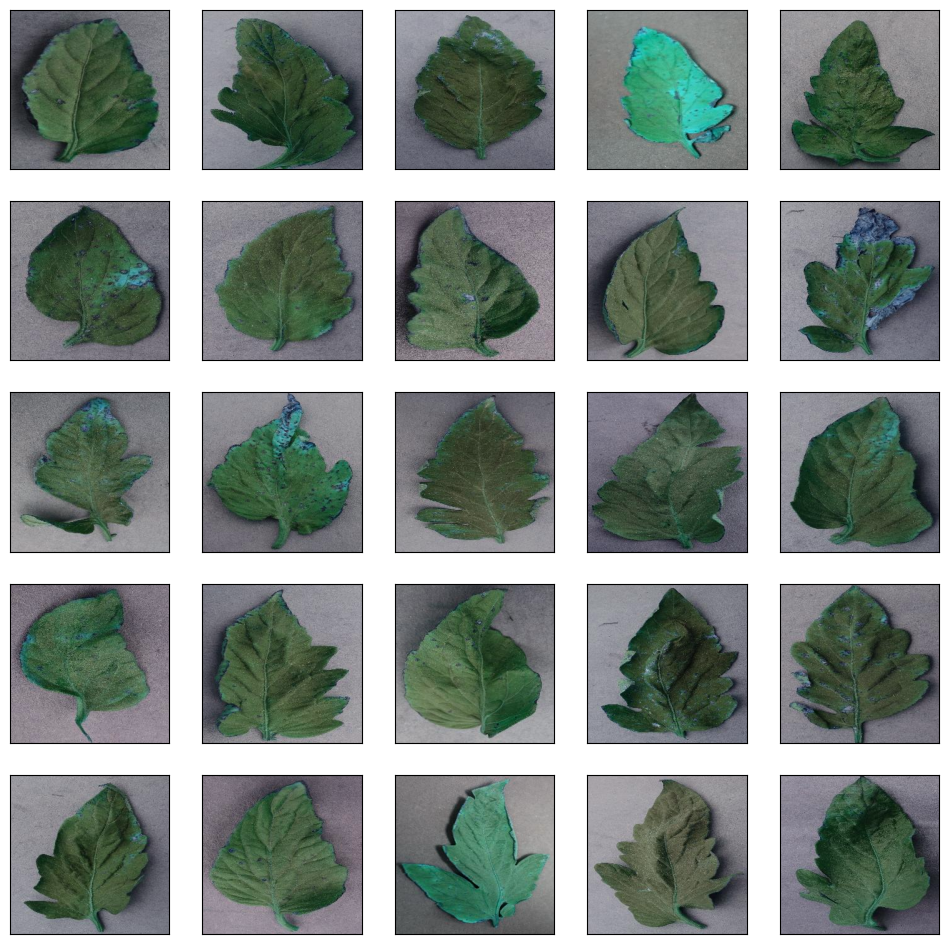

In [15]:
def disease_type(disease_type, rows, cols):
    fig,ax = plt.subplots(rows, cols, figsize=(12,12))
    disease_type = train['File'][train['Disease Type'] == disease_type].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(train_dir, disease_type[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
disease_type('tomato_bacterial-spot', 5, 5)

**Let's look at some healthy samples**

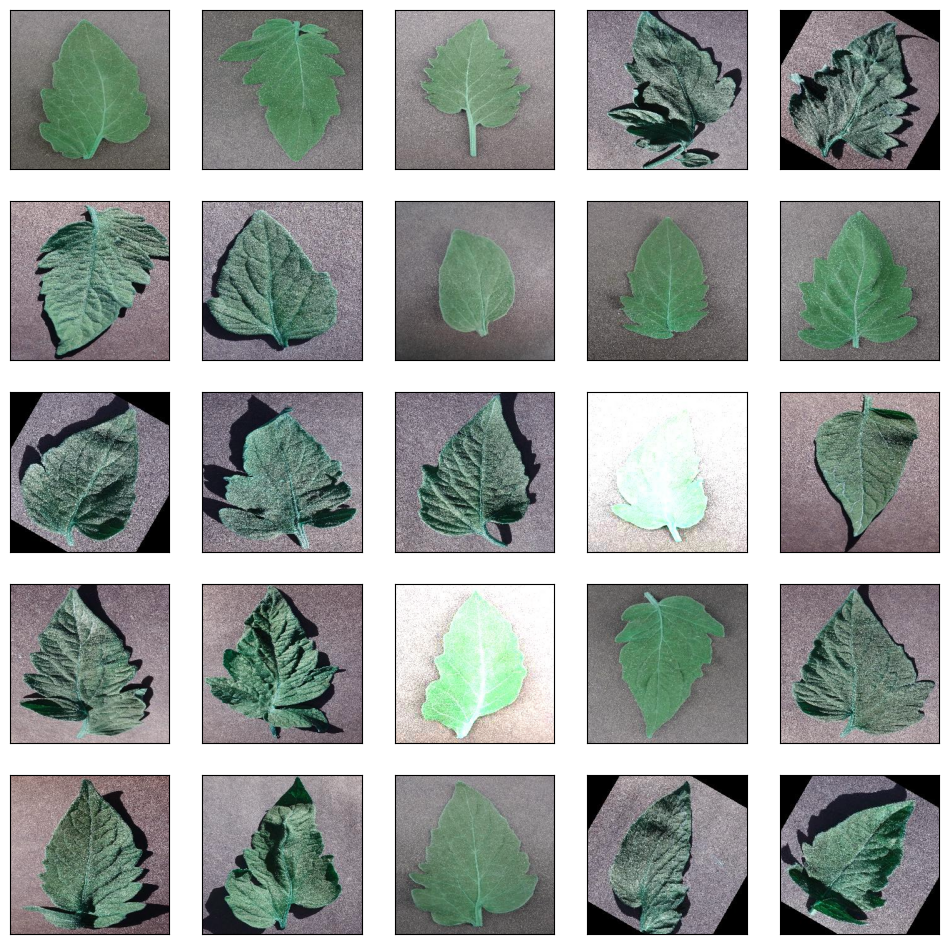

In [16]:
disease_type('tomato_healthy', 5, 5)

## Image Data Augmentation

In [17]:
import tensorflow as tf

def create_image_data_generators(data_dir, image_size, batch_size, do_data_augmentation):
    # Rescale the images
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

    # Validation generator
    validation_generator = datagen.flow_from_directory(
        val_dir,  # Point to the Val directory
        shuffle=False,
        seed=42,
        color_mode="rgb",
        class_mode="categorical",
        target_size=image_size,
        batch_size=batch_size)

    if do_data_augmentation:
        # Enable data augmentation
        train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
            rescale=1./255,
            rotation_range=40,
            horizontal_flip=True,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            fill_mode='nearest')
    else:
        # Disable data augmentation
        train_datagen = datagen

    # Train generator
    train_generator = train_datagen.flow_from_directory(
        train_dir,  # Point to the Train directory
        shuffle=True,
        seed=42,
        color_mode="rgb",
        class_mode="categorical",
        target_size=image_size,
        batch_size=batch_size)

    # Test generator
    test_generator = datagen.flow_from_directory(
        test_dir,  # Point to the Test directory
        shuffle=False,
        seed=42,
        color_mode="rgb",
        class_mode="categorical",
        target_size=image_size,
        batch_size=batch_size)

    return train_generator, validation_generator, test_generator


In [18]:
data_dir = data_dir
train_dir = train_dir
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
do_data_augmentation = True
train_generator, validation_generator, test_generator = create_image_data_generators(data_dir, IMAGE_SIZE, BATCH_SIZE, do_data_augmentation)

Found 12067 images belonging to 29 classes.
Found 53690 images belonging to 29 classes.
Found 1354 images belonging to 29 classes.


# Build Model

## Create Callbacks for easy maintenance while training

In [19]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.model = model
        self.patience = patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience = stop_patience # specifies how many times to adjust lr without improvement to stop training
        self.threshold = threshold # training accuracy threshold for lr adjustment based on validation loss
        self.factor = factor # factor to reduce the learning rate
        self.batches = batches # number of training batches per epoch
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch # save this value to restore if restarting training

        # callback variables
        self.count = 0 # how many times lr has been reduced without improvement
        self.stop_count = 0
        self.best_epoch = 1   # epoch with the lowest loss
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initial learning rate
        self.highest_tracc = 0.0 # initial highest training accuracy
        self.lowest_vloss = np.inf # initial lowest validation loss
        self.best_weights = self.model.get_weights() # store initial weights
        self.initial_weights = self.model.get_weights()   # save initial weights for restoration if needed

    def on_train_begin(self, logs=None):
        print('Do you want the model to ask you to halt the training [y/n]?')
        ans = input('').strip().lower()
        self.ask_permission = 1 if ans == 'y' else 0

        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format(
            'Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
        print(msg)
        self.start_time = time.time()

    def on_train_end(self, logs=None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        print(f'Training elapsed time: {hours:.0f} hours, {minutes:.0f} minutes, {seconds:.2f} seconds')
        self.model.set_weights(self.best_weights)  # restore best weights

    def on_train_batch_end(self, batch, logs=None):
        # Limit printing to every 10 batches or any other interval
        if batch % 10 == 0:
            acc = logs.get('accuracy') * 100
            loss = logs.get('loss')
            print(f'Processing batch {batch} of {self.batches} - Accuracy: {acc:.3f}% - Loss: {loss:.5f}', '\r', end='')

    def on_epoch_begin(self, epoch, logs=None):
        self.ep_start = time.time()

    def on_epoch_end(self, epoch, logs=None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))  # current learning rate
        acc = logs.get('accuracy')  # training accuracy
        v_acc = logs.get('val_accuracy')  # validation accuracy
        loss = logs.get('loss')  # training loss
        v_loss = logs.get('val_loss')  # validation loss

        # Adjust learning rate based on training accuracy and validation loss
        if acc < self.threshold:
            monitor = 'accuracy'
            pimprov = (acc - self.highest_tracc) * 100 / self.highest_tracc if self.highest_tracc != 0 else 0
            if acc > self.highest_tracc:
                self.highest_tracc = acc
                self.best_weights = self.model.get_weights()
                self.count = 0
                self.stop_count = 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1
            else:
                self.count += 1
                if self.count >= self.patience:
                    lr *= self.factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr)
                    self.count = 0
                    self.stop_count += 1
        else:
            monitor = 'val_loss'
            pimprov = (self.lowest_vloss - v_loss) * 100 / self.lowest_vloss if self.lowest_vloss != np.inf else 0
            if v_loss < self.lowest_vloss:
                self.lowest_vloss = v_loss
                self.best_weights = self.model.get_weights()
                self.count = 0
                self.stop_count = 0
                self.best_epoch = epoch + 1
            else:
                self.count += 1
                if self.count >= self.patience:
                    lr *= self.factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr)
                    self.stop_count += 1
                    self.count = 0

        msg = f'{epoch + 1:^3}/{self.epochs:^4} {loss:^9.3f} {acc * 100:^9.3f} {v_loss:^9.5f} {v_acc * 100:^9.3f} {lr:^9.5f} {monitor:^11s} {pimprov:^10.2f} {duration:^8.2f}'
        print(msg)

        if self.stop_count >= self.stop_patience:
            print(f'Training halted at epoch {epoch + 1} after {self.stop_patience} learning rate adjustments with no improvement.')
            self.model.stop_training = True

        if self.ask_permission and epoch + 1 >= self.ask_epoch:
            print('Enter H to halt training or an integer for the number of epochs to continue:')
            ans = input('').strip().lower()
            if ans == 'h':
                print(f'Training halted at epoch {epoch + 1} due to user input.')
                self.model.stop_training = True
            else:
                try:
                    self.ask_epoch += int(ans)
                    print(f'Training will continue until epoch {self.ask_epoch}')
                except ValueError:
                    print('Invalid input')


## Create custom plot

In [20]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']

    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    Epochs = [i+1 for i in range(len(tr_acc))]

    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()


## Create the model layers

In [21]:
class_count = train_generator.num_classes
print(class_count)
print("Building custom CNN model")

model = tf.keras.Sequential([
    # First block of Conv2D + MaxPooling
    Conv2D(32, (3, 3), activation='relu', input_shape=IMAGE_SIZE + (3,)),
    BatchNormalization(),  # Add batch normalization to stabilize learning
    MaxPooling2D(2, 2),

    # Second block of Conv2D + MaxPooling
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Third block of Conv2D + MaxPooling
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Fourth block of Conv2D + MaxPooling
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Flatten the 2D output to 1D for the dense layers
    Flatten(),

    # Dense layers
    Dense(512, kernel_regularizer=regularizers.l2(0.016), activation='relu'),
    Dropout(rate=0.5, seed=123),

    Dense(256, kernel_regularizer=regularizers.l2(0.016), activation='relu'),
    Dropout(rate=0.5, seed=123),

    # Output layer (softmax)
    Dense(class_count, activation='softmax')
])

model.summary()


29
Building custom CNN model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 64)      256       
 chNormalization)                                                
                           

# Specifying Loss Functions

In [22]:
model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 64)      256       
 chNormalization)                                                
                                                        

## Set all hyper parameter and variabel for custom training

In [23]:
batch_size = 40   # set batch size for training
epochs = 20   # number of all epochs in training
patience = 1   #number of epochs to wait to adjust lr if monitored value does not improve
stop_patience = 3   # number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9   # if train accuracy is < threshold adjust monitor accuracy, else monitor validation loss
factor = 0.5   # factor to reduce lr by
ask_epoch = 5   # number of epochs to run before asking if you want to halt training
batches = int(np.ceil(12 / batch_size))    # number of training batch to run per epoch

callbacks = [MyCallback(model= model, patience= patience, stop_patience= stop_patience, threshold= threshold,
            factor= factor, batches= batches, epochs= epochs, ask_epoch= ask_epoch )]

## Start train the model

In [24]:
history = model.fit(x= train_generator, epochs= epochs, verbose= 0, callbacks= callbacks,
                    validation_data= validation_generator, validation_steps= validation_generator.samples // validation_generator.batch_size)

Do you want the model to ask you to halt the training [y/n]?


 n


 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration


I0000 00:00:1728088536.692150     153 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 1 / 20   11.264    24.457    4.99811   48.649    0.00100   accuracy      0.00     602.36 
 2 / 20    3.789    59.169    3.14447   67.225    0.00100   accuracy     141.93    593.90 
 3 / 20    2.255    79.050    1.73624   86.257    0.00100   accuracy     33.60     599.42 
 4 / 20    1.553    86.117    1.52638   82.162    0.00100   accuracy      8.94     594.81 
 5 / 20    1.213    89.533    1.15965   89.647    0.00100   accuracy      3.97     594.31 
 6 / 20    1.062    91.091    1.02690   92.034    0.00100   val_loss     11.45     588.16 
 7 / 20    0.978    92.222    1.08897   89.348    0.00050   val_loss     -6.04     588.76 
 8 / 20    0.659    94.863    0.56276   95.051    0.00050   val_loss     45.20     588.04 
 9 / 20    0.541    95.239    0.57561   93.576    0.00025   val_loss     -2.28     587.23 
10 / 20    0.427    96.424    0.36948   96.311    0.00025   val_loss     34.35     588.69 
11 / 20    0.368    96.510    0.36375   95.797    0.00025   val_loss      1.55     589.89 

## Plot history using custom plot

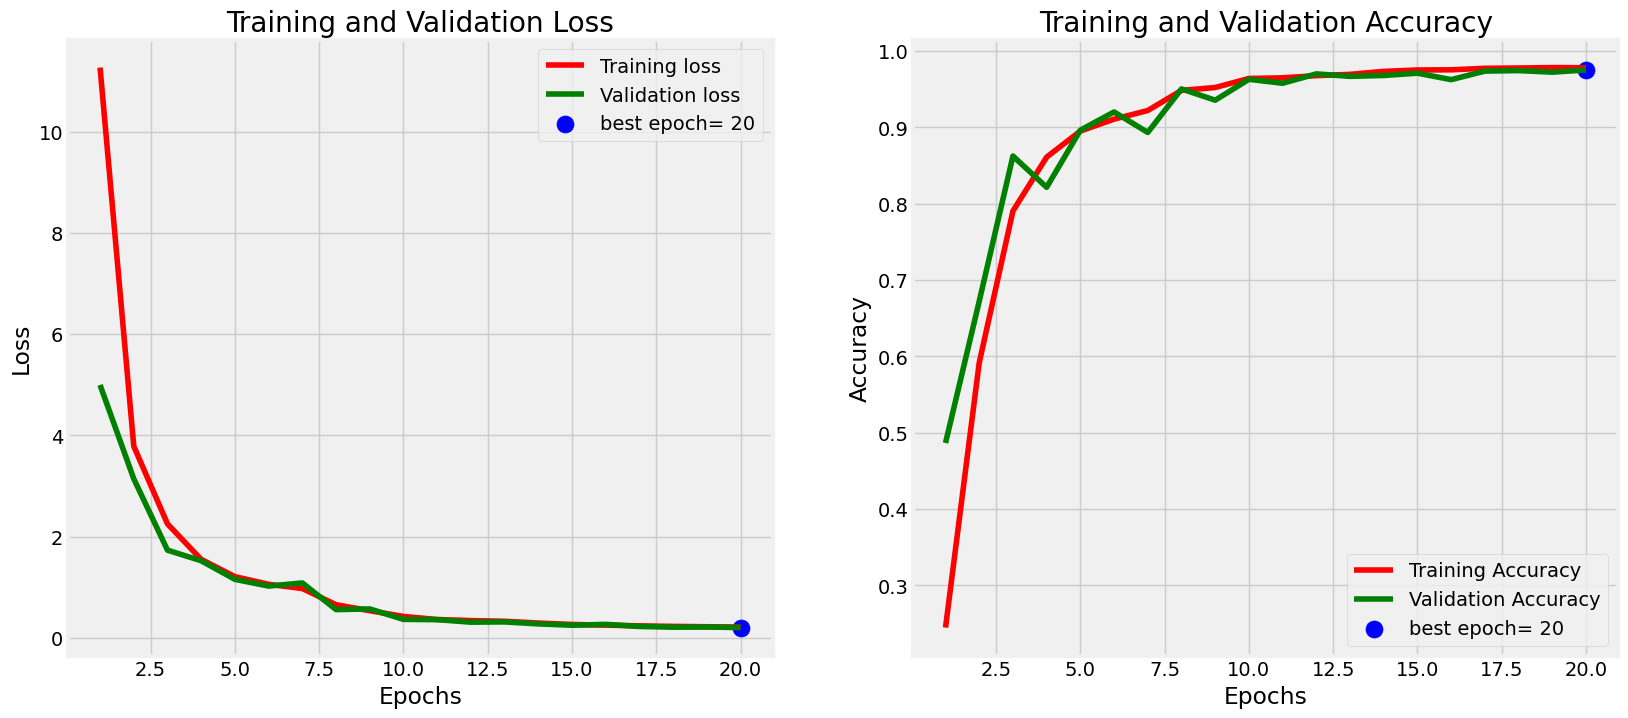

In [25]:
plot_training(history)

# Evaluation

## Evaluation using validation generator from dataset split

In [26]:
preds = model.predict(validation_generator, steps=5)
label = validation_generator.classes
pred = model.predict(validation_generator)

predicted_class_indices=np.argmax(pred,axis=1)

378/378 [==============================] - 17s 45ms/step


In [27]:
labels = (validation_generator.class_indices)
labels2 = dict((v,k) for k,v in labels.items())
predictions = [labels2[k] for k in predicted_class_indices]

## Confusion report

In [28]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

cf_report = classification_report(predicted_class_indices,label)
cm = confusion_matrix(predicted_class_indices,label)

print(cf_report)

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       430
           1       0.99      1.00      0.99       392
           2       0.97      0.98      0.98       448
           3       0.99      1.00      0.99       448
           4       1.00      1.00      1.00       410
           5       0.98      0.99      0.99       373
           6       0.96      0.92      0.94       385
           7       1.00      1.00      1.00       428
           8       1.00      1.00      1.00       420
           9       0.94      0.97      0.95       417
          10       0.98      0.99      0.99       418
          11       1.00      0.99      0.99       433
          12       1.00      0.98      0.99       387
          13       0.99      0.98      0.99       394
          14       0.98      1.00      0.99       407
          15       0.98      1.00      0.99       380
          16       0.99      0.99      0.99       429
          17       1.00    

## Confusion matrix

Text(0.5, 160.08333333333326, 'Predicted')

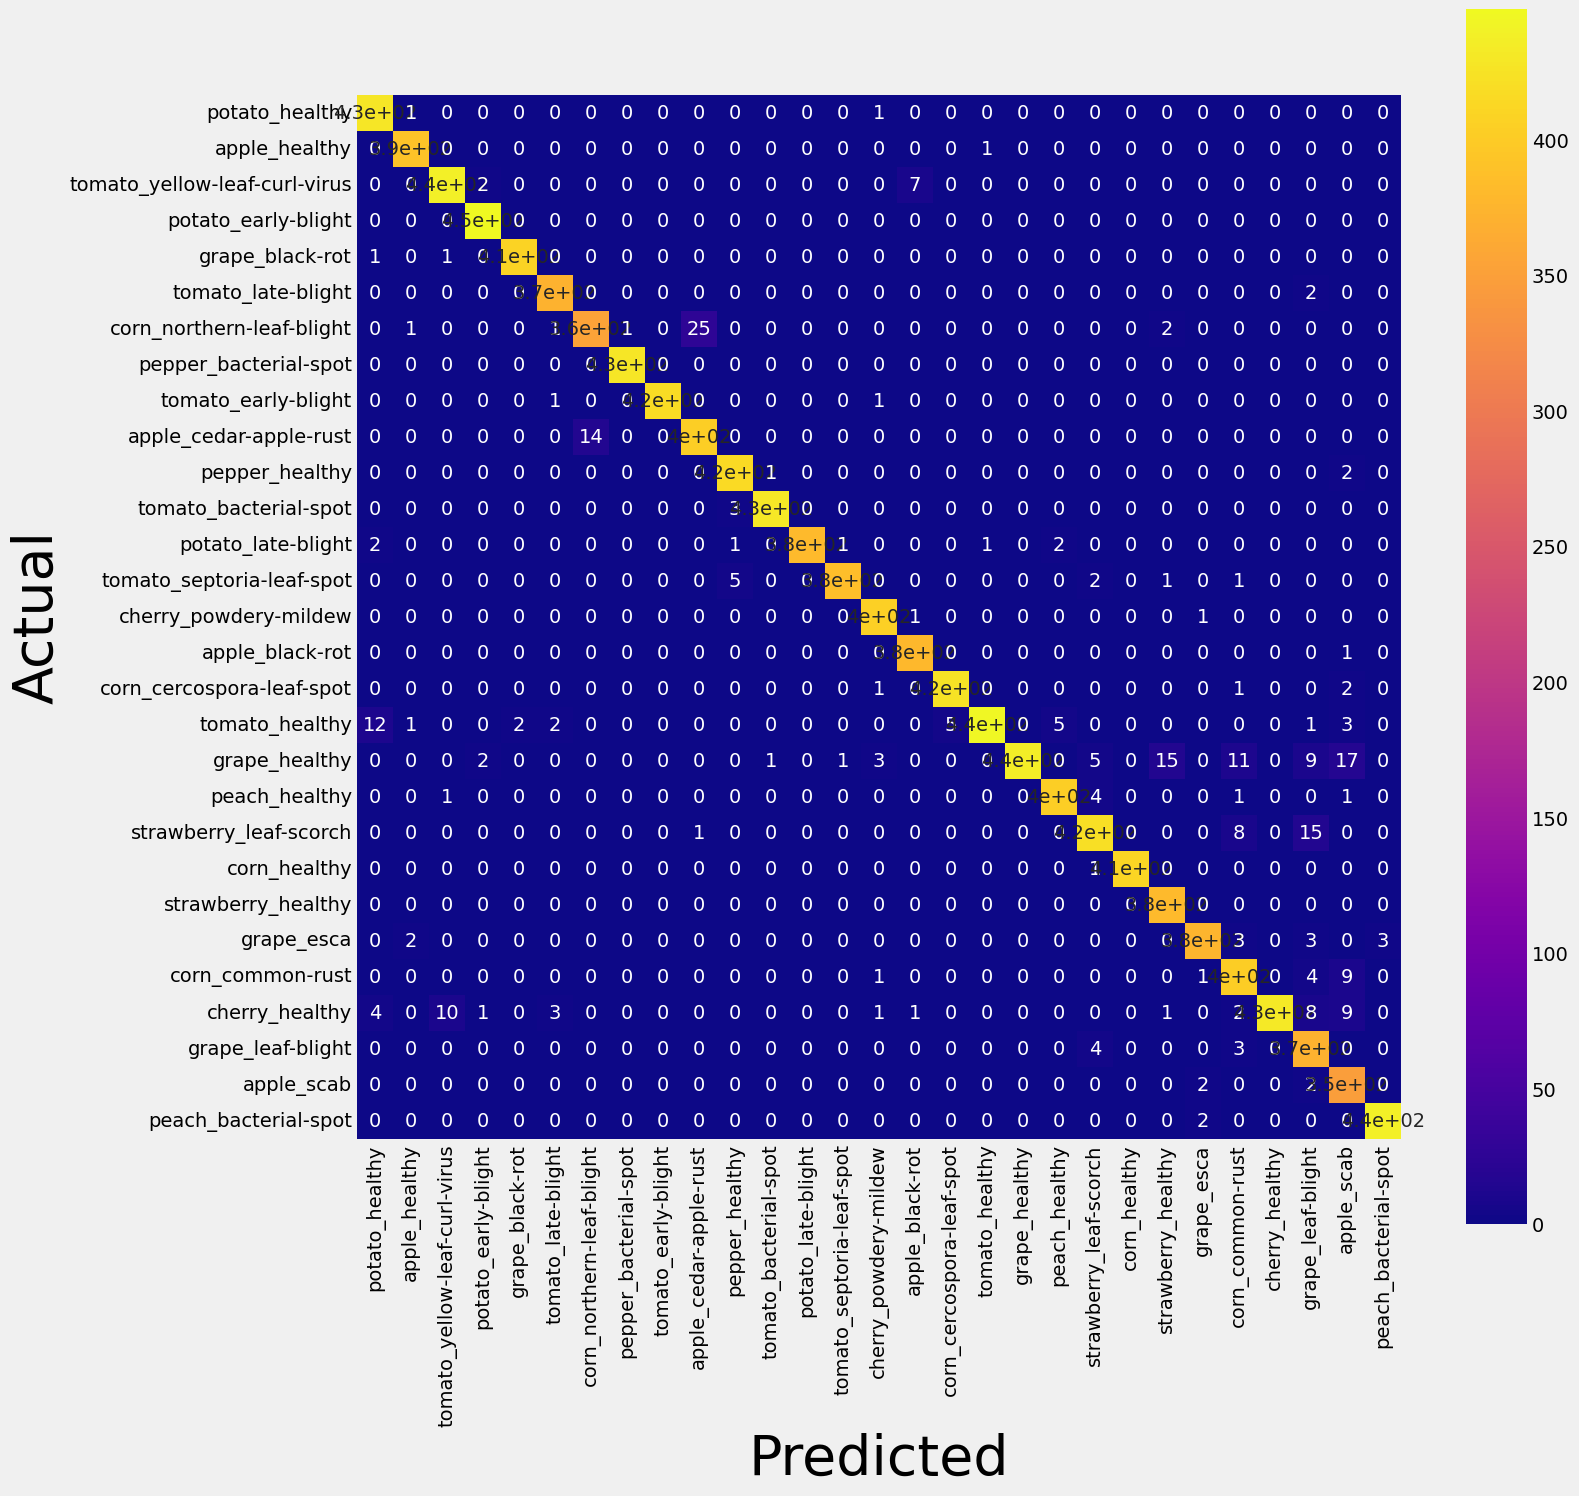

In [29]:
plt.figure(figsize=(15,15))
ax = sns.heatmap(cm, cmap=plt.cm.plasma, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)

ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

# Saving Model

In [30]:
import shutil
import tensorflow as tf

# Path to save the model
path = '/kaggle/working/model_fix'

# Save the model
tf.saved_model.save(model, path)

# Name for the ZIP file
zip_file_name = '/kaggle/working/model-fix'

# Create a ZIP file
shutil.make_archive(zip_file_name, 'zip', path)

# The model is now saved as a zip file in '/kaggle/working/'
# You can access and download this file from the Kaggle environment


'/kaggle/working/model-fix.zip'

## Image testing

In [31]:
# prompt: create a code to test the model using 10 random images that is inside the test_dir

import numpy as np
import random
import matplotlib.pyplot as plt

# Get a list of all image files in the test directory
image_files = [os.path.join(test_dir, f) for f in os.listdir(test_dir) if os.path.isfile(os.path.join(test_dir, f))]

# Select 10 random image files
num_images_to_test = 10
random_image_files = random.sample(image_files, num_images_to_test)

# Loop through the selected images
for image_file in random_image_files:
  # Load the image
  img = cv2.imread(image_file)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, IMAGE_SIZE)

  # Make a prediction
  img_array = np.expand_dims(img, axis=0)
  prediction = model.predict(img_array)
  predicted_class_index = np.argmax(prediction)
  predicted_class_label = list(test_generator.class_indices.keys())[list(test_generator.class_indices.values()).index(predicted_class_index)]


  # Display the image and prediction
  plt.imshow(img)
  plt.title(f"Predicted: {predicted_class_label}")
  plt.axis('off')
  plt.show()


ValueError: Sample larger than population or is negative